In [1]:
#install required packages
import sys
!pip install atlasopenmagic
%pip install "pyarrow>=20.0.0"
# from atlasopenmagic import install_from_environment
# install_from_environment(environment_file="environment.yml")

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import awkward as ak 
import vector
import time
import uproot
import glob
import pickle
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator, AutoMinorLocator # for minor ticks

sys.path.append('./backend')
#from GetInputMagic import get_samples_magic
from ValidateVariables import validate_variables
from GetInput import get_samples
from RunAnalysisUproot import analysis
from PlotHistogramAk import plot_histogram

The string code for the available final-state collections:

* '2to4lep' - two to four leptons with at least 7 GeV of $p_T$ each
* '2muons' - at least two muons with at least 10 GeV of $p_T$
* 'GamGam' - at least two photons with at least 25 GeV of $p_T$ each
* 'exactly4lep' - exactly four leptons with at least 7 GeV of $p_T$

The string code for the available Monte Carlo simulation dataset:
* 'Zee'
* 'Zmumu'
* 'Ztautau'
* 'Wlepnu'
* 'ttbar'
* 'H'
* 'ZZllll'

Please use '+' to combine data sets. For example, if you want to combine the data for the physics processes of $Z\rightarrow\tau\tau$ and $ZZ^{*}\rightarrow llll$, write 'Ztautau+ZZllll'.

Please include '**Data**' in the key defined for the final-state collection and '**Signal**' for the physical processes simulated by the MC. Remember, strings in Python are case-sensitive! Please do not include 'Data' in the key if you don't want to store the real data as its value. Likewise, please avoid having 'Signal' in the key if it is not a Monte Carlo simulated data set that models the physics process that you want to study.
The functions defined to analyse and plot the data rely heavily on the presence of the keywords '**Data**' and '**Signal**'. Please see the scripts in the backend folder if you are interested in how the functions are defined. You are recommended not to modify the scripts in the backend folder.

In [3]:
keys_input = ['Background $Z→ee$, $W→lν$',
              'Signal $Z→μμ$',
              'Data 2to4lep']

string_codes_input = ['Zee+Wlepnu', 
                      'Zmumu',
                      '2to4lep']

keys_input = ['Data 2to4lep']
string_codes_input = ['2to4lep']



In [4]:
samples = get_samples(keys_input, string_codes_input)
print(samples)

{'Data 2to4lep': {'files': ['./backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodD.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodE.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodF.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodG.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodH.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodJ.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_periodA.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_periodB.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_periodC.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_periodD.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_periodE.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_periodF.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_periodG.2to4lep.root', './backend

In [5]:
luminosity = 36.6
fraction = 1
# Define what variables are important to our analysis
variables = ["lep_n", "lep_pt", "lep_eta", "lep_phi", "lep_e", 
             #"lep_ptvarcone30", "lep_topoetcone20", 
             "lep_type", "lep_charge",
             #"lep_isLooseID", "lep_isMediumID", "lep_isTightID",
             #"lep_isLooseIso", "lep_isTightIso",
             #"trigE",
             "trigM", "lep_isTrigMatched"]


In [6]:
variables = validate_variables(variables)

In [7]:
# Note: first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
# Functions return bool. True means we should remove the event

# Function to cut on the number of leptons in each event
def cut_lep_n(lep_n, user_input):
    return (lep_n == user_input)

# Function to cut on the lepton type (based on type of first two lep_type)
# lep_type is a number signifying the lepton type (electron (11) or muon (13))
def cut_lep_type(lep_type, user_input):
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1] # Sum of first two leptons' type in the event 
    return (sum_lep_type == user_input)

# Function to cut on the lepton charge (based on charge of first two lep_charge)
def cut_lep_charge(lep_charge, user_input):
    product_lep_charge = lep_charge[:, 0] * lep_charge[:, 1] # Product of first two leptons' charge in the event
    return (product_lep_charge == user_input)

# Function to cut on the lepton transverse momentum
def cut_lep_pt(lep_pt, index, lower_limit):
    return (lep_pt[:, index] > lower_limit) # Accept events with lepton pt higher than lower limit

# Function to cut on the isolation pt (based on first two leptons)
def cut_lep_ptvarcone30(lep_ptvarcone30, upper_limit):
    # Accept events with lep_ptvarcone30 in the range
    return (lep_ptvarcone30[:, 0] < upper_limit) & (lep_ptvarcone30[:, 1] < upper_limit)

# Function to cut on the isolation et (based on first two leptons)
def cut_lep_topoetcone20(lep_topoetcone20, upper_limit):
    # Accept events with lep_topoetcone20 in the range
    return (lep_topoetcone20[:, 0] < upper_limit) & (lep_topoetcone20[:, 1] < upper_limit)

# Function to accept events with at least one lepton is triggering
def cut_trig_match(lep_trigmatch): 
    return ak.sum(lep_trigmatch, axis=1) >= 1

# # Function to accept events that has been selected by any of the single electron OR muon triggers
# def cut_trig(trigE, trigM):
#     return trigE | trigM

# Function to accept events that has been selected by any of the single electron OR muon triggers
def cut_trig(trigM):
    return trigM

# # Function to filter events based on the identification and isolation criteria of all leptons in each event
# def ID_iso_cut(electron_isID, muon_isID, electron_isIso, muon_isIso, lep_type, lep_n): 
#     return (ak.sum(((lep_type == 13) & muon_isID & muon_isIso) | 
#                    ((lep_type == 11) & electron_isID & electron_isIso), axis=1) == lep_n)

# Function to keep events that have all leptons passed the identification and isolation criteria
def ID_iso_cut(lep_isID, lep_isIso, lep_n): 
    return (ak.sum(lep_isID & lep_isIso, axis=1) == lep_n)

# Function to calculate the invariant mass using four momentum (pt, eta, phi, energy)    
def calculate_inv_mass(lep_pt, lep_eta, lep_phi, lep_e):
    four_momentum = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_e})
    invariant_mass = (four_momentum[:, 0] + four_momentum[:, 1]).M

    return invariant_mass

def selection_cut(data):
    # Keep events that pass electron / muon trigger 
    data = data[cut_trig(data['trigM'])]
    # Keep events where at least one lepton is triggering
    data = data[cut_trig_match(data['lep_isTrigMatched'])]

    # Lepton cuts
    lep_n = data['lep_n']
    data = data[cut_lep_n(lep_n, 2)]
          
    lep_type = data['lep_type']
    data = data[cut_lep_type(lep_type, 26)]
    
    lep_charge = data['lep_charge']
    data = data[cut_lep_charge(lep_charge, -1)]
    
    # Invariant Mass
    data['mass'] = calculate_inv_mass(data['lep_pt'], data['lep_eta'], data['lep_phi'], data['lep_e'])

    return data

In [ ]:
filename = '26-06-2025.txt'

# Save data
all_data = analysis(luminosity, fraction, samples, selection_cut, variables,
                    ['lep_pt'], filename)

Processing Data 2to4lep samples
	./backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodD.2to4lep.root:
		 nIn: 880210,	 nOut: 	56978	 in 2.4s
	./backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodE.2to4lep.root:
		 nIn: 1747950,	 nOut: 	127267	 in 5.4s
		 nIn: 1747950,	 nOut: 	127086	 in 10.9s
		 nIn: 1747950,	 nOut: 	136061	 in 16.1s
		 nIn: 1282318,	 nOut: 	96219	 in 19.7s
	./backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodF.2to4lep.root:
		 nIn: 1748102,	 nOut: 	137798	 in 5.3s
		 nIn: 1748102,	 nOut: 	136371	 in 10.1s
		 nIn: 687081,	 nOut: 	52263	 in 12.0s
	./backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodG.2to4lep.root:
		 nIn: 1747091,	 nOut: 	153491	 in 5.0s
		 nIn: 1747091,	 nOut: 	149194	 in 10.1s
		 nIn: 1747091,	 nOut: 	148505	 in 15.1s
		 nIn: 1747091,	 nOut: 	138480	 in 20.6s
		 nIn: 1747091,	 nOut: 	140169	 in 25.5s
		 nIn: 632819,	 nOut: 	57745	 in 27.4s
	./backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodH.2to4lep.root:
		 nIn: 1742226,	 nOut: 	1

In [27]:
all_data.keys()

dict_keys(['Data 2to4lep'])

In [28]:
for i in all_data:
    print(i + f' Events: {all_data[i]['events']}')

Data 2to4lep Events: 1580420


In [29]:
mc_dist = {key : value for key, value in all_data.items()
           if 'Data' not in key}
for key, value in mc_dist.items():
    print(value['results']) # This might return an empty array though results is a dict with keys
    print(value['results'].fields)

In [30]:
mc_dist

{}

Elapsed time = 0.1s


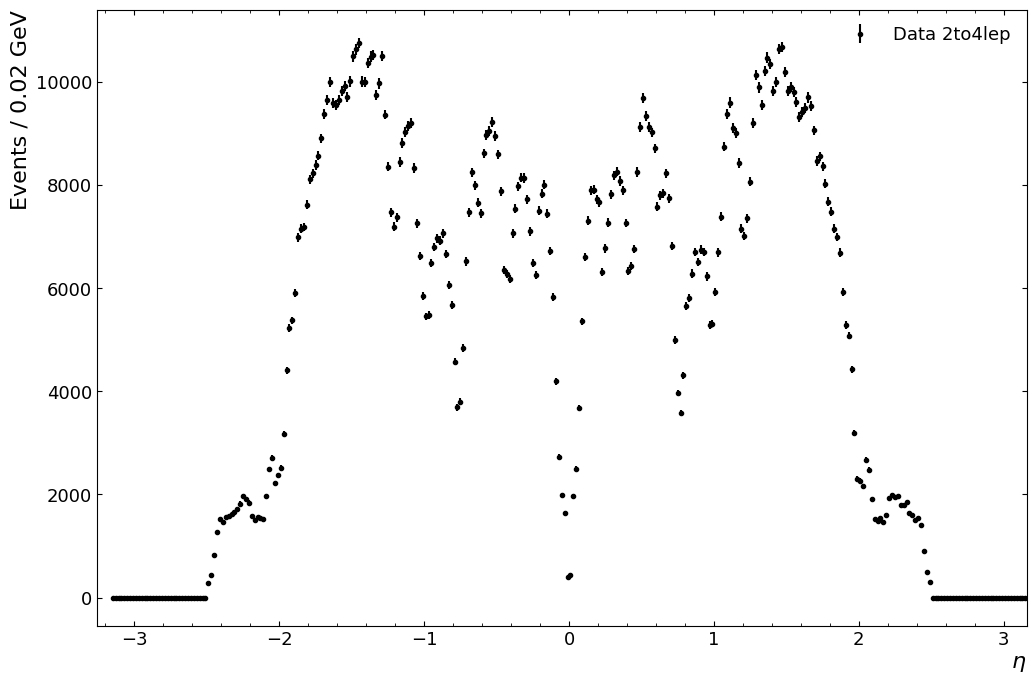

In [35]:
colors_input = ["m", # purple
                "g", # green
                "k"] # black

colors_input = ["k"] # black

GeV = 1.0
# x-axis range of the plot
xmin = 0 * GeV
xmax = 120 * GeV
xmin = -3.16
xmax = 3.16


# Histogram bin setup
step_size = 0.02

fig, ax = plot_histogram(all_data, 'lep_eta', colors_input,
                         xmin, xmax,
                         step_size,
                         'lep_$\eta$ [0]', scalar_variable=False,
                         y_label='Events / ',
                         marker='.', label_fontsize=16, title='')


Elapsed time = 0.0s


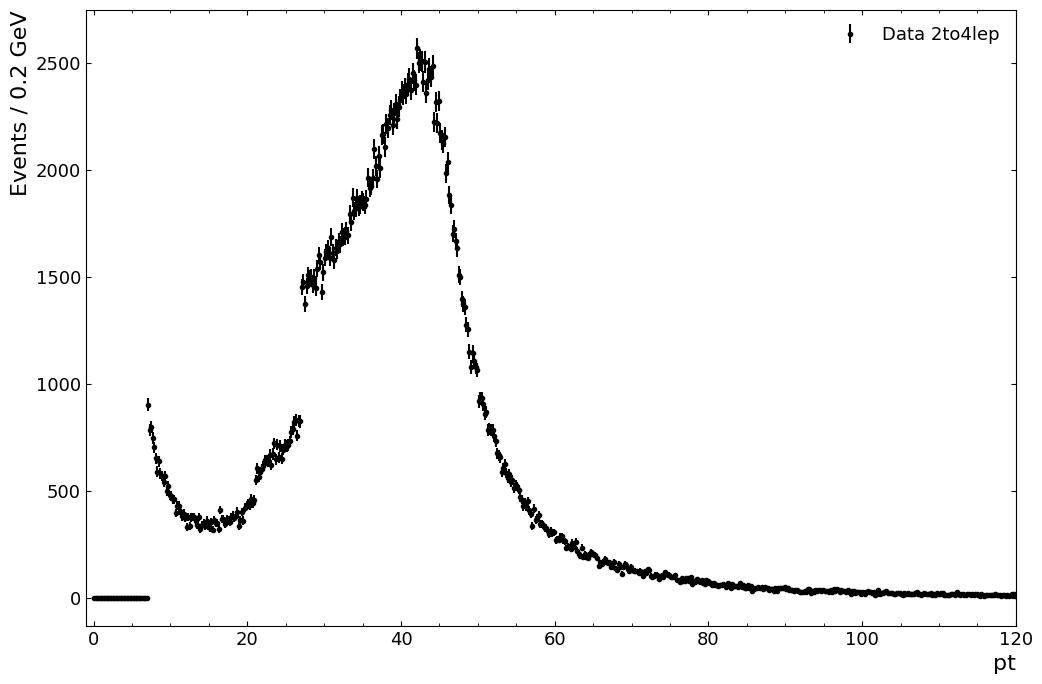

In [14]:
fig, ax = plot_histogram(all_data, 'lep_pt', colors_input,
                         xmin, xmax,
                         step_size,
                         'pt', scalar_variable=False, index=1,
                         marker='.', label_fontsize=16, title='')

In [39]:
save_variable = 'lep_eta'

pickle_output_file = f"lumi{luminosity}_frac{fraction}_{save_variable}"

In [40]:
with open(f"pkl/{pickle_output_file}.pkl", "wb") as f:
    pickle.dump(all_data, f)

In [41]:
with open(f"pkl/{pickle_output_file}.pkl", "rb") as f:
    loaded_data = pickle.load(f)

Elapsed time = 0.1s


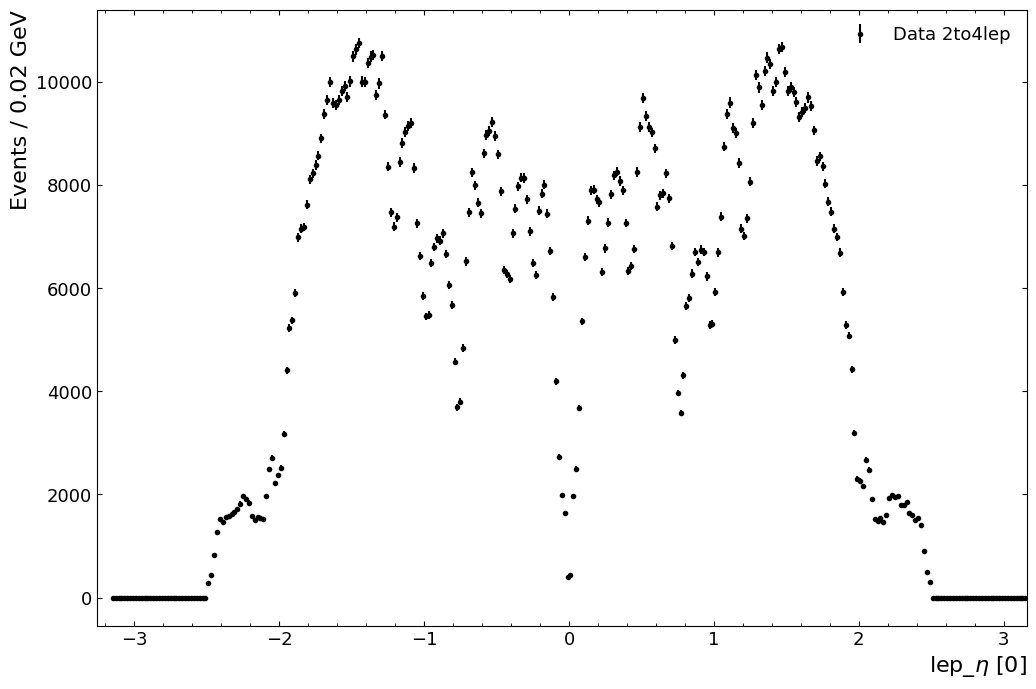

In [42]:
fig, ax = plot_histogram(loaded_data, 'lep_eta', colors_input,
                         xmin, xmax,
                         step_size,
                         'lep_$\eta$ [0]', scalar_variable=False,
                         y_label='Events / ',
                         marker='.', label_fontsize=16, title='')


In [ ]:
fig.savefig('histogram.png')

In [ ]:
#analysis_parquet(luminosity, fraction, samples, selection_cut, variables, ['lep_pt'], 'parquet-test')

In [ ]:
#pt = get_data(samples, 'lep_pt')
# need validate input for variable

In [ ]:
# def concatenate_chunks(directory, variable):
#     sample_data = [ak.from_parquet(file, columns = [variable])
#                    for file in sorted(glob.glob(f'{directory}/*.parquet'))]
#     results = ak.concatenate(sample_data)
#     return results[variable]

# def get_data_pq(samples, variable, color_list, index=0, scalar_variable=True):
    
#     all_data = {}
    
#     for sample_key, color in zip(samples, color_list):
#         directory = f"output/{sample_key}"
#         data = concatenate_chunks(directory, variable)
        
#         all_data[sample_key] = {'color' : color}

#         if not scalar_variable:
#             all_data[sample_key][variable + f'_{index}'] = data[:, index]
#         else: 
#             all_data[sample_key][variable] = data

#         if 'Data' not in sample_key:
#             # if not scalar_variable:
#             #     all_data[sample_key]['totalWeight'] = weight[:, index]
#             # else:
#             #     all_data[sample_key]['totalWeight'] = weight
#             all_data[sample_key]['totalWeight'] = concatenate_chunks(directory, 'totalWeight')
                
#     return all_data
        

In [ ]:
# keys_input = [r'Background $Z\rightarrow ee$, $W\rightarrow l\nu$',
#               r'Signal $Z\rightarrow\mu\mu$',
#               'Data 2to4lep']
# colors_input = ["m", # purple
#                 "g", # green
#                 "k"] # black
# pt = get_data_pq(keys_input, 'lep_pt', colors_input, scalar_variable=False)

In [ ]:
# GeV = 1.0
# # x-axis range of the plot
# xmin = 0 * GeV
# xmax = 120 * GeV

# # Histogram bin setup
# step_size = 0.2 * GeV

# plot_histogram_pq(pt, 'lep_pt_0',
#                          xmin, xmax,
#                          step_size,
#                          '$p_T$ [GeV]',
#                          marker='.', label_fontsize=16, title='')

In [ ]:
#pt1 = get_data_pq(keys_input, 'lep_pt', colors_input, index=1, scalar_variable=False)

In [ ]:
# plot_histogram_pq(pt1, 'lep_pt_1',
#                          xmin, xmax,
#                          step_size,
#                          '$p_T$ [GeV]',
#                          marker='.', label_fontsize=16, title='')